# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in Turi Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!

# Import Neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import string
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

# Load LendingClub Dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

In [2]:
loans = pd.read_csv('lending-club-data.csv')
loans

c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.143500,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.393200,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.259550,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.275850,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.215330,20141201T000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122602,9856168,11708132,6000,6000,6000,60 months,23.40,170.53,E,E5,...,1.0,0.0,1.0,1.0,1,4.487630,20190101T000000,0,1,0
122603,9795013,11647121,15250,15250,15250,36 months,17.57,548.05,D,D2,...,0.4,0.0,0.0,1.0,0,10.117800,20170101T000000,0,0,0
122604,9695736,11547808,8525,8525,8525,60 months,18.25,217.65,D,D3,...,0.6,0.0,1.0,1.0,0,6.958120,20190101T000000,0,1,0
122605,9684700,11536848,22000,22000,22000,60 months,19.97,582.50,D,D5,...,1.0,1.0,0.0,1.0,0,8.961540,20190101T000000,1,0,1


## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [3]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [5]:
loans = loans[[target] + features].dropna()

Fortunately, there are not too many missing values. We are retaining most of the data.Fortunately, as you should find, there are not too many missing values. We are retaining most of the data.

## One Hot Encoding

In [6]:
catergorical_vars = [var for var in loans.columns if loans[var].dtypes == object]
loans = pd.get_dummies(loans)

## Split data into training and validation sets

In [7]:
train_indices = pd.read_json('module-8-assignment-1-train-idx.json')
train_indices = train_indices.rename({0: 'indices'}, axis=1)
train_indices = list(train_indices['indices'])

validation_indices = pd.read_json('module-8-assignment-1-validation-idx.json')
validation_indices = validation_indices.rename({0: 'indices'}, axis=1)
validation_indices = list(validation_indices['indices'])

train_data = loans.iloc[train_indices]
validation_data = loans.iloc[validation_indices]

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [Turi Create user guide](https://apple.github.io/turicreate/docs/api/generated/turicreate.boosted_trees_classifier.BoostedTreesClassifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)

Now, let's use the built-in scikit learn gradient boosting classifier (sklearn.ensemble.GradientBoostingClassifier) to create a gradient boosted classifier on the training data. You will need to import **sklearn**, **sklearn.ensemble**, and **numpy**.

You will have to first convert the DataFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. Make sure to set **max_depth=6** and **n_estimators=5**

In [8]:
clf = GradientBoostingClassifier(n_estimators=5, max_depth=6)
model_5 = clf.fit(train_data.drop('safe_loans', axis=1),train_data['safe_loans'])

# Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

First, let's grab 2 positive examples and 2 negative examples. In pandas, that would be:

In [9]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


### Predicting on sample validation data

For each row in the **sample_validation_data**, write code to make **model_5** predict whether or not the loan is classified as a **safe loan**.

**Hint:** Use the `predict` method in `model_5` for this.

In [10]:
predictions = model_5.predict(sample_validation_data.drop('safe_loans', axis=1))
print('The predicitons are : ', predictions)

# The code below is to answer the following quiz question

acc = round(clf.score(sample_validation_data.drop('safe_loans', axis=1),sample_validation_data['safe_loans']),2)
print('\nThe accuracy of model_5 on sample_validation_data is : ', acc)

The predicitons are :  [ 1  1 -1  1]

The accuracy of model_5 on sample_validation_data is :  0.75


<font color='steelblue'><b> Quiz : What percentage of the predictions on sample_validation_data did model_5 get correct? </b></font>

<font color='mediumvioletred'><b> Answer : model_5 got {{acc * 100}} % of predictions correct on sample_validation_data </b></font>

### Prediction probabilities

For each row in the **sample_validation_data**, what is the probability (according **model_5**) of a loan being classified as **safe**? 

In [11]:
predictions_probs = model_5.predict_proba(sample_validation_data.drop('safe_loans', axis=1))

# The code below is to answer the following quiz questions 

probs_safe = [predictions_probs[i][1] for i in range(len(sample_validation_data))]
safest_loan = probs_safe.index(max(probs_safe)) + 1

print('Loan', safest_loan, 'has the highest probability of being classified as safe loan')

'''Checkpoint : Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?'''

for i in range(len(sample_validation_data)) : 
    if predictions_probs[i][1] >= 0.5 and predictions_probs[i][0] < 0.5 :
        verify = 'Yes, for all the predicitions with probability >= 0.5, the model predicted the label +1'
    else :
        verify = 'No, for all the predicitions with probability >= 0.5, the model does not predicted the label +1'

print('\n' + verify)

Loan 4 has the highest probability of being classified as safe loan

Yes, for all the predicitions with probability >= 0.5, the model predicted the label +1


<font color='steelblue'><b> Quiz : Which loan has the highest probability of being classified as a safe loan? </b></font>

<font color='mediumvioletred'><b> Answer : Loan {{safest_loan}} has the highest probability of being classified as safe loan </b></font>

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**. (Hint: if you are using scikit-learn, you can use the **.score()** method)

In [12]:
model_5_accuracy = round(model_5.score(validation_data.drop('safe_loans',axis=1), validation_data['safe_loans']),2)
model_5_accuracy

0.66

Calculate the number of **false positives** made by the model.

In [13]:
predictions_safeloans = model_5.predict(validation_data.drop('safe_loans',1))
false_positives = sum(predictions_safeloans > validation_data['safe_loans'])

print('Total Number of False Positives on validation data: ', false_positives)

Total Number of False Positives on validation data:  1654


<font color='steelblue'><b> Quiz : What is the number of false positives on the validation_data? </b></font>

<font color='mediumvioletred'><b> Answer : Total Number of False Positives on validation data : {{false_positives}}  </b></font>

In [14]:
predictions_safeloans = model_5.predict(validation_data.drop('safe_loans',1))
false_negatives = sum(predictions_safeloans < validation_data['safe_loans'])

print('Total Number of False negatives on validation data: ', false_negatives)

Total Number of False negatives on validation data:  1491


<font color='steelblue'><b> Quiz : What is the number of false negatives on the validation_data? </b></font>

<font color='mediumvioletred'><b> Answer : Total Number of False Negatives on validation data : {{false_negatives}}  </b></font>

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

Calculate the cost of mistakes made by **model_5** on the **validation_data**.

In [15]:
cost = false_negatives*10000 + false_positives*20000
cost

47990000

<font color='steelblue'><b> Quiz : Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set? </b></font>

<font color='mediumvioletred'><b> Answer : Total Number of False Negatives on validation data : Total cost of mistakes made by model_5 : ${{cost/1000000}}M  </b></font>

**Reminder**: Compare the cost of the mistakes made by the boosted trees model with the decision tree model. The extra 3% improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

Checkpoint: For each row, the probabilities should be a number in the range [0, 1].

In [16]:
safe_loans = model_5.predict_proba(validation_data.drop('safe_loans',axis=1))
validation_data['predictions'] = [safe_loans[i][1] for i in range(len(validation_data))]
validation_data['predictions']

# Checkpoint
for i in range(len(safe_loans)) :
    if safe_loans[i][0] > 1 or  safe_loans[i][0] < 0 or safe_loans[i][1] > 1 or safe_loans[i][1] < 0 :
        checkpoint = False
        
    else :
        checkpoint = True
        
if checkpoint == True :
        print('Checkpoint Passed!')
else :
    print('Checkpoint Failed!')

Checkpoint Passed!


c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [17]:
sorted_validation_data = validation_data.sort_values(by='predictions', ascending=False).iloc[0:5,22:28]

# The code below is to answer the following quiz question
grades = []

if 1 in sorted_validation_data['grade_A'].values :
    grades.append('grade_A')

if 1 in sorted_validation_data['grade_B'].values :
    grades.append('grade_B')
    
if 1 in sorted_validation_data['grade_C'].values :
    grades.append('grade_C')
    
if 1 in sorted_validation_data['grade_D'].values :
    grades.append('grade_D')
    
if 1 in sorted_validation_data['grade_E'].values :
    grades.append('grade_E')
    
if 1 in sorted_validation_data['grade_F'].values :
    grades.append('grade_F')
    
if len(grades)==1 :
    print(*grades, 'is in the Top 5 loans')
else :
    print(*grades, 'are in the Top 5 loans')


grade_A is in the Top 5 loans


<font color='steelblue'><b> Quiz : What grades are the top 5 loans? </b></font>

<font color='mediumvioletred'><b> Answer : {{grades}} are in top 5 loans </b></font>

Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

## Effect of adding more trees

In this assignment, we train 5 different ensemble classifiers in the form of gradient boosted trees. 

Train models with 10, 50, 100, 200, and 500 trees.  Use the **n_estimators** parameter to control the number of trees. Remember to keep **max_depth = 6**.

Call these models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**, respectively. This may take a few minutes to run.

In [18]:
clf_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
model_10 = clf_10.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

clf_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
model_50 = clf_50.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

clf_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)
model_100 = clf_100.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

clf_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6)
model_200 = clf_200.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

clf_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6)
model_500 = clf_500.fit(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set.

Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**.

In [19]:
model_10_acc = clf_10.score(validation_data.drop(['safe_loans', 'predictions'],axis=1), validation_data['safe_loans'])
model_50_acc = clf_50.score(validation_data.drop(['safe_loans', 'predictions'],axis=1), validation_data['safe_loans'])
model_100_acc = clf_100.score(validation_data.drop(['safe_loans', 'predictions'],axis=1), validation_data['safe_loans'])
model_200_acc = clf_200.score(validation_data.drop(['safe_loans', 'predictions'],axis=1), validation_data['safe_loans'])
model_500_acc = clf_500.score(validation_data.drop(['safe_loans', 'predictions'],axis=1), validation_data['safe_loans'])

print('Accuracy of model_10 is  : ', model_10_acc)
print('Accuracy of model_50 is  : ', model_50_acc)
print('Accuracy of model_100 is : ', model_100_acc)
print('Accuracy of model_200 is : ', model_200_acc)
print('Accuracy of model_500 is : ', model_500_acc)

# The code below is to answer the following quiz questions

accuracies = [model_10_acc, model_50_acc, model_100_acc, model_200_acc, model_500_acc]
model_names = ['model_10', 'model_50', 'model_100', 'model_200', 'model_500']
nums = [10, 50, 100, 200, 500]

accs_dict = dict(zip(model_names,accuracies))

best_acc = max(accs_dict, key=accs_dict.get)
print('\n' + best_acc, 'has the best accuracy on validation data')

for i in range(len(accuracies)) :
    if nums.index(max(nums)) == accuracies.index(max(accuracies)) :
        ans = 'Yes, it is always true that the model with most trees will perform best on test data'
    else :
        ans = 'No, it is not always true that the model with most trees will perform best on test data'
        
print('\n' + ans)

Accuracy of model_10 is  :  0.6663076260232659
Accuracy of model_50 is  :  0.6852649719948298
Accuracy of model_100 is :  0.6884963377854373
Accuracy of model_200 is :  0.6889271865575183
Accuracy of model_500 is :  0.6892503231365791

model_500 has the best accuracy on validation data

Yes, it is always true that the model with most trees will perform best on test data


<font color='steelblue'><b> Quiz 1 : Which model has the best accuracy on the validation_data? </b></font>

<font color='mediumvioletred'><b> Answer 1 : {{best_acc}} has the best accuracy on validation data </b></font>

<br/>

<font color='steelblue'><b> Quiz 2 : Is it always true that the model with the most trees will perform best on test data? </b></font>

<font color='mediumvioletred'><b> Answer 2 : {{ans}} </b></font>

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the training and validation errors versus the number of trees to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. **You will need [matplotlib] to visualize the plots**. 

First, make sure this block of code runs on your computer.

In [20]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of the errors

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [21]:
train_err_10 = 1 - clf_10.score(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
train_err_50 = 1 - clf_50.score(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
train_err_100 = 1 - clf_100.score(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
train_err_200 = 1 - clf_200.score(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])
train_err_500 = 1 - clf_500.score(train_data.drop('safe_loans', axis=1), train_data['safe_loans'])

print('train_err_10  : ', train_err_10)
print('train_err_50  : ', train_err_50)
print('train_err_100 : ', train_err_100)
print('train_err_200 : ', train_err_200)
print('train_err_500 : ', train_err_500)

train_err_10  :  0.3283269297939224
train_err_50  :  0.282597598001021
train_err_100 :  0.25409065262365993
train_err_200 :  0.21497084822268198
train_err_500 :  0.13681184341331043


Now, let us run **Step 2**. Save the training errors into a list called **training_errors**

In [22]:
training_errors = [train_err_10, train_err_50, train_err_100, train_err_200, train_err_500]

Now, onto **Step 3**. Write code to compute the classification error on the **validation_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [23]:
validation_err_10 = 1 - model_10_acc
validation_err_50 = 1 - model_50_acc
validation_err_100 = 1 - model_100_acc
validation_err_200 = 1 - model_200_acc
validation_err_500 = 1 - model_500_acc

print('validation_err_10  : ', validation_err_10)
print('validation_err_50  : ', validation_err_50)
print('validation_err_100 : ', validation_err_100)
print('validation_err_200 : ', validation_err_200)
print('validation_err_500 : ', validation_err_500)

validation_err_10  :  0.3336923739767341
validation_err_50  :  0.31473502800517017
validation_err_100 :  0.3115036622145627
validation_err_200 :  0.3110728134424817
validation_err_500 :  0.3107496768634209


Now, let us run **Step 4**. Save the training errors into a list called **validation_errors**

In [24]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, validation_err_200, validation_err_500]

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

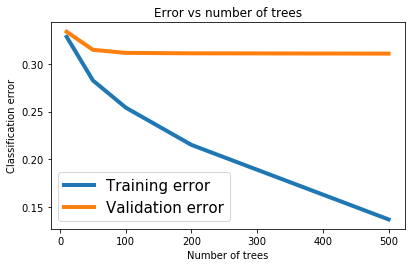



Yes, training error reduce as the number of trees increases

No, it is not always true that the validation error will reduce as the number of trees increases


In [25]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')
plt.show()

# The code below is to answer the following quiz questions

for previous, current in zip(training_errors, training_errors[1:]) :
    if previous > current :
        ans_1 = 'Yes, training error reduce as the number of trees increases'
    else :
        ans_1 = 'No, training error does not always reduce as the number of trees increases'
    
for previous, current in zip(validation_errors, validation_errors[1:]) :
    if previous < current :
        ans_2 = 'Yes, it is always true that the validation error will reduce as the number of trees increases'
    else :
        ans_2 = 'No, it is not always true that the validation error will reduce as the number of trees increases'
        
print('\n\n' + ans_1)
print('\n' + ans_2)

<font color='steelblue'><b> Quiz 1 : Does the training error reduce as the number of trees increases? </b></font>

<font color='mediumvioletred'><b> Answer 1 : {{ans_1}} </b></font>

<br/>

<font color='steelblue'><b> Quiz 2 : Is it always true that the validation error will reduce as the number of trees increases? </b></font>

<font color='mediumvioletred'><b> Answer 2 : {{ans_2}} </b></font>